# 1. Introduction of ADMM pruning

# 2. AlexNet

In [13]:
# Import essential modules
import sys
sys.path.append('src')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

from dataloader.ImageNet_dataloader import ImageNetDataLoader
from dataloader.CIFAR_dataloader import CIFARDataLoader

from SimplePruning_Toolbox import admm_pruning
from SimplePruning_Toolbox.utils import train, evaluate, count_nonzero_params

from AlexNet import AlexNet
from LeNet_5 import LeNet5
from VGG_8 import VGG_8

In [4]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Define AlexNet Network
model_AlexNet = AlexNet()

Files already downloaded and verified
Files already downloaded and verified


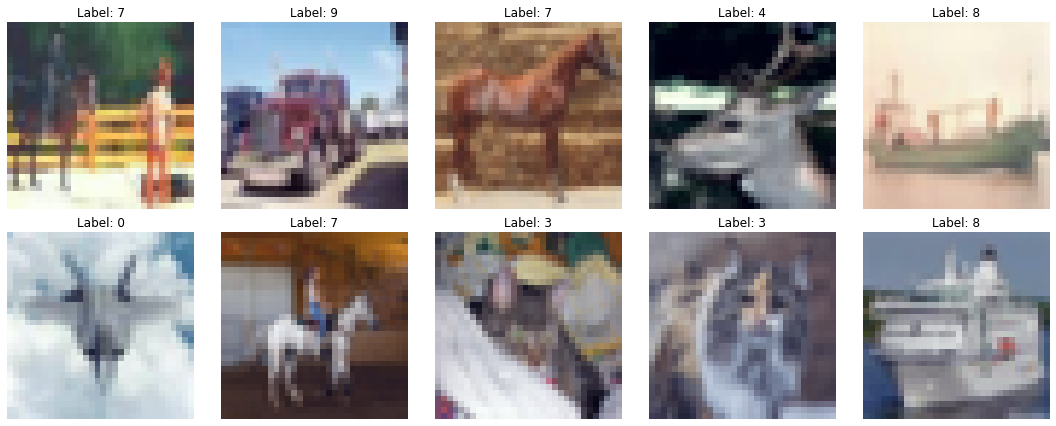

In [23]:
#Load and Visialize ImageNet dataloader
batch_size = 800
img_size = 224

# Load data for training
train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

# Load data for testing
test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get the first 10 images and labels from the batch
images = images[:10]
labels = labels[:10]

# Conver to cpu and numpy
images = images.cpu().numpy()
images = images.transpose(0, 2, 3, 1)

images = (images - images.min()) / (images.max() - images.min())

# images = (images * 0.5) + 0.5

# Compose the 10 images into a single plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Display Un-pruned evaluation results
model_AlexNet.load_state_dict(torch.load('src/AlexNet/best_model.pth'))
test_loss, accuracy = evaluate(model_AlexNet, test_loader, device, nn.CrossEntropyLoss())
print(f'Original model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Original model, Test Loss: 2.3247, Accuracy: 0.7078


# Part 3 - LeNet

In [25]:
# Define LeNet-5 Network
model_LeNet = LeNet5()

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



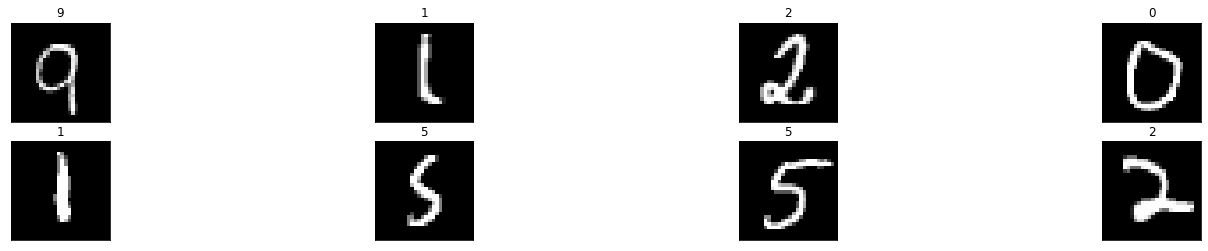

In [26]:
# Load and Visialize MNIST dataloader
batch_size = 256

train_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Plot the images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

plt.show()

Epoch 5 - Training loss: 0.0654
Epoch 10 - Training loss: 0.0299
Epoch 15 - Training loss: 0.0181
Epoch 20 - Training loss: 0.0095
Epoch 25 - Training loss: 0.0077
Epoch 30 - Training loss: 0.0058


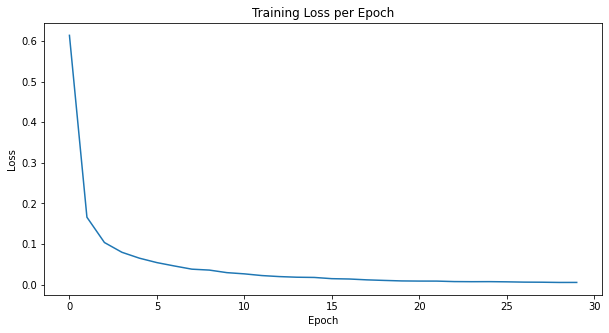

In [30]:
# Train and Load Pre-trained Best Model parameters
from SimplePruning_Toolbox.utils import train

   
epochs = 30
best_loss = float('inf')
losses = []

for epoch in range(epochs):
    avg_loss = train(model_LeNet, 
            train_loader, 
            device, 
            optimizer = optim.Adam(model_LeNet.parameters(), 
            lr=1e-3), 
            criterion = nn.CrossEntropyLoss(), mask=None)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} - Training loss: {avg_loss:.4f}")
    losses.append(avg_loss)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model_LeNet.state_dict(), 'best_model_LeNet.pth')
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()


In [31]:
# Display Un-pruned evaluation results
model_LeNet.load_state_dict(torch.load('best_model_LeNet.pth'))
test_loss, accuracy = evaluate(model_LeNet, test_loader, device, nn.CrossEntropyLoss())
print(f'Original model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Original model, Test Loss: 0.0470, Accuracy: 0.9894


# Part 2:
Model Pruning

In [35]:
# Define ADMM Pruning method
percent = [0.95, 0.95, 0.95, 0.95, 0.95]

In [37]:
#Load data for training
train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

#Load data for testing
test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
#TODO: Apply ADMM pruning method to AlexNet
model2 = AlexNet()
percent = [0.8, 0.92, 0.93, 0.94, 0.95, 0.99, 0.99, 0.93]
model2.load_state_dict(torch.load('best_model_AlexNet.pth'))
pruned_model, mask = admm_pruning(model2, train_loader, percent)
test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Pruned model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/10
normalized norm of (weight - projection)
(features.0.weight): 0.6787
(features.3.weight): 0.7021
(features.6.weight): 0.6616
(features.8.weight): 0.7247
(features.10.weight): 0.7843
(classifier.1.weight): 0.9214
(classifier.4.weight): 0.8833
(classifier.6.weight): 0.4307
Test Loss: 4.1627, Accuracy: 0.1000
Epoch 2/10
normalized norm of (weight - projection)
(features.0.weight): 0.3932
(features.3.weight): 0.3329
(features.6.weight): 0.3866
(features.8.weight): 0.3691
(features.10.weight): 0.4573
(classifier.1.weight): 0.7903
(classifier.4.weight): 0.8296
(classifier.6.weight): 0.2447
Test Loss: 3.5326, Accuracy: 0.1000
Epoch 3/10
normalized norm of (weight - projection)
(features.0.weight): 0.4818
(features.3.weight): 0.3429
(features.6.weight): 0.3239
(features.8.weight): 0.3262
(features.10.weight): 0.3761
(classifier.1.weight): 0.5710
(classifier.4.weight): 0.5163
(classifier.6.weight): 0.1078
Test Loss: 3.4130, Accuracy: 0.1273
Epoch 4/10
normalized norm of (weight - pro

Number of nonzero parameters in original model: 23272266
Number of nonzero parameters in pruned model: 360159


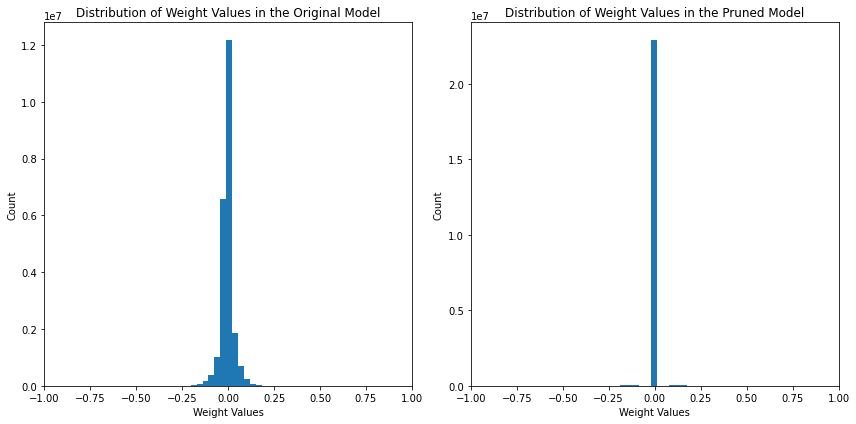

In [39]:
#TODO: Visualize model parameter changes and model size changes of AlexNet
from SimplePruning_Toolbox.utils import count_nonzero_params
print(f'Number of nonzero parameters in original model: {count_nonzero_params(model_AlexNet)}')
print(f'Number of nonzero parameters in pruned model: {count_nonzero_params(pruned_model)}')

# Plot the distribution of weights in the original and pruned models
weights_leorignal = []
weights_lepruned = []
for param in model_AlexNet.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)  
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()

In [40]:
#Retrain the model of AlexNet
fine_tune_epochs = 10
optimizer = optim.Adam(pruned_model.parameters(), lr=1e-3)
for epoch in range(fine_tune_epochs):
    train(pruned_model, train_loader, device, optimizer=optimizer, criterion = nn.CrossEntropyLoss(), mask = mask)
    test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
    print(f'Epoch: {epoch + 1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

# Save the pruned model
torch.save(pruned_model.state_dict(), 'pruned_model_AlexNet.pth')

Epoch: 1, Test Loss: 1.5394, Accuracy: 0.4748
Epoch: 2, Test Loss: 1.4657, Accuracy: 0.5040
Epoch: 3, Test Loss: 1.3646, Accuracy: 0.5425
Epoch: 4, Test Loss: 1.2778, Accuracy: 0.5695
Epoch: 5, Test Loss: 1.3285, Accuracy: 0.5552
Epoch: 6, Test Loss: 1.2398, Accuracy: 0.5856
Epoch: 7, Test Loss: 1.2324, Accuracy: 0.5893
Epoch: 8, Test Loss: 1.2251, Accuracy: 0.5907
Epoch: 9, Test Loss: 1.1713, Accuracy: 0.6043
Epoch: 10, Test Loss: 1.1555, Accuracy: 0.6121


In [41]:
#Compare the evluation results of AlexNet
test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Pruned model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Pruned model, Test Loss: 1.1516, Accuracy: 0.6121


In [ ]:
# Apply ADMM pruning method to LeNet-5
model2 = LeNet5()
train_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
model2.load_state_dict(torch.load('best_model_LeNet.pth'))
pruned_model, mask = admm_pruning(model2, train_loader, percent)
test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Pruned model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/10
Test Loss: 2.4807, Accuracy: 0.0953
Epoch 2/10
Test Loss: 2.4344, Accuracy: 0.1876
Epoch 3/10
Test Loss: 2.2632, Accuracy: 0.2987
Epoch 4/10
Test Loss: 2.0175, Accuracy: 0.4364
Epoch 5/10
Test Loss: 1.7689, Accuracy: 0.5131
Epoch 6/10
Test Loss: 1.5305, Accuracy: 0.5891
Epoch 7/10
Test Loss: 1.3000, Accuracy: 0.6829
Epoch 8/10
Test Loss: 1.1111, Accuracy: 0.7450
Epoch 9/10
Test Loss: 0.9454, Accuracy: 0.8025
Epoch 10/10
Test Loss: 0.8230, Accuracy: 0.8411
Pruned model, Test Loss: 0.5891, Accuracy: 0.8403


Number of nonzero parameters in original model: 61706
Number of nonzero parameters in pruned model: 3310


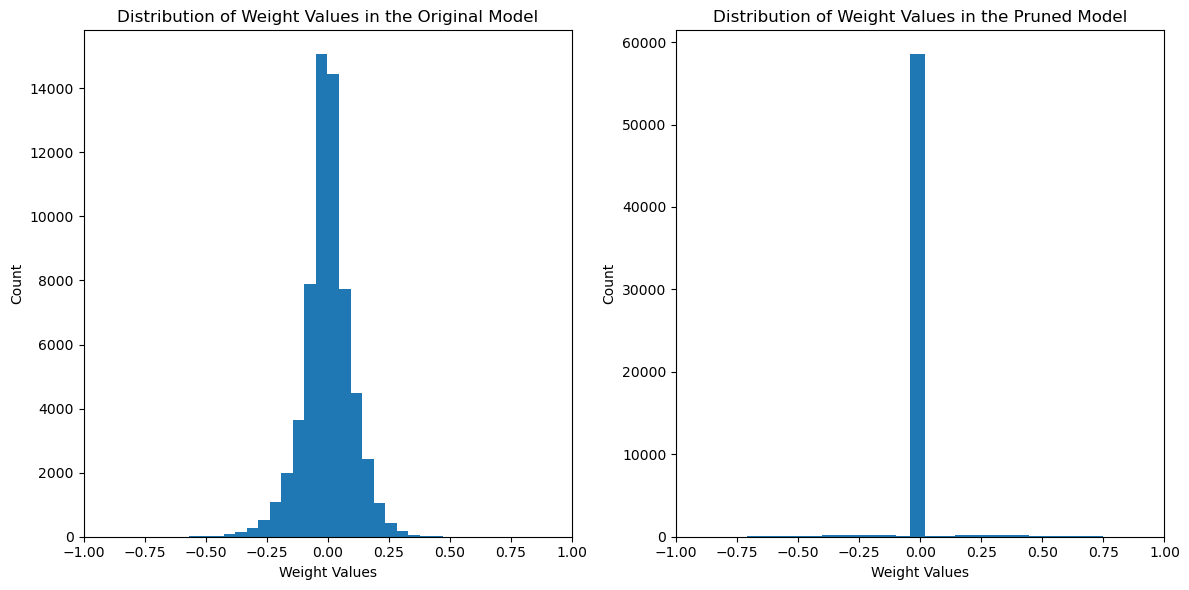

In [ ]:
# Visualize model parameter changes and model size changes of LeNet-5
print(f'Number of nonzero parameters in original model: {count_nonzero_params(model_LeNet)}')
print(f'Number of nonzero parameters in pruned model: {count_nonzero_params(pruned_model)}')

# Plot the distribution of weights in the original and pruned models
weights_leorignal = []
weights_lepruned = []
for param in model_LeNet.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)  
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()


In [ ]:
# Retrain the model of LeNet-5
fine_tune_epochs = 5
optimizer = optim.Adam(pruned_model.parameters(), lr=1e-3)
for epoch in range(fine_tune_epochs):
    utils.train(pruned_model, train_loader, device, optimizer=optimizer, criterion = nn.CrossEntropyLoss(), mask = mask)
    test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
    print(f'Epoch: {epoch + 1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch: 1, Test Loss: 0.5194, Accuracy: 0.8588
Epoch: 2, Test Loss: 0.4420, Accuracy: 0.8830
Epoch: 3, Test Loss: 0.4019, Accuracy: 0.8915
Epoch: 4, Test Loss: 0.3575, Accuracy: 0.9024
Epoch: 5, Test Loss: 0.3217, Accuracy: 0.9093


Comparison of origianl and pruned LeNet-5
|  | Pretrained Model | Pruned Model | Retrained Model |
|---------|---------|---------|---------|
| Size |61706  | 3310 | 3310 |
| Accuracy | 0.9914 | 0.8403 | 0.9093 |


# 4. VGG-8

In [15]:
# Define and load VGG-8 Network
model_VGG = VGG_8()
model_VGG.load_state_dict(torch.load('models/VGG_best_model.pth'))

<All keys matched successfully>

In [2]:
batch_size = 512

#Load data for training
train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

#Load data for testing
test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Apply ADMM pruning method to AlexNet
model_VGG_2 = VGG_8()
percent = [0.85] * 9
model_VGG_2.load_state_dict(torch.load('models/VGG_best_model.pth'))
test_loss, accuracy = evaluate(model_VGG_2, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Original model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
pruned_model, mask = admm_pruning(model_VGG_2, train_loader, percent)
test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Pruned model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Original model, Test Loss: 1.0378, Accuracy: 0.8021
Epoch 1/10
normalized norm of (weight - projection)
(features.0.weight): 0.7570
(features.2.weight): 0.5801
(features.5.weight): 0.5881
(features.7.weight): 0.6086
(features.10.weight): 0.5962
(features.12.weight): 0.5291
(classifier.0.weight): 0.3717
(classifier.3.weight): 0.5201
(classifier.6.weight): 0.5265
Test Loss: 9.2747, Accuracy: 0.1012
Epoch 2/10
normalized norm of (weight - projection)
(features.0.weight): 0.3757
(features.2.weight): 0.3007
(features.5.weight): 0.2749
(features.7.weight): 0.2957
(features.10.weight): 0.2936
(features.12.weight): 0.3274
(classifier.0.weight): 0.3477
(classifier.3.weight): 0.3784
(classifier.6.weight): 0.2540
Test Loss: 2.9315, Accuracy: 0.1512
Epoch 3/10
normalized norm of (weight - projection)
(features.0.weight): 0.5102
(features.2.weight): 0.3052
(features.5.weight): 0.2871
(features.7.weight): 0.3061
(features.10.weight): 0.2980
(features.12.weight): 0.2588
(classifier.0.weight): 0.2172


In [11]:
# Retrain the model of VGG-8
fine_tune_epochs = 5
optimizer = optim.Adam(pruned_model.parameters(), lr=1e-3)
for epoch in range(fine_tune_epochs):
    train(pruned_model, train_loader, device, optimizer=optimizer, criterion = nn.CrossEntropyLoss(), mask=mask)
    test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
    print(f'Epoch: {epoch + 1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch: 1, Test Loss: 0.6920, Accuracy: 0.7836
Epoch: 2, Test Loss: 0.6800, Accuracy: 0.7918
Epoch: 3, Test Loss: 0.6847, Accuracy: 0.7958
Epoch: 4, Test Loss: 0.7025, Accuracy: 0.8014
Epoch: 5, Test Loss: 0.7124, Accuracy: 0.8018


Number of nonzero parameters in original model: 6400586
Number of nonzero parameters in pruned model: 962603


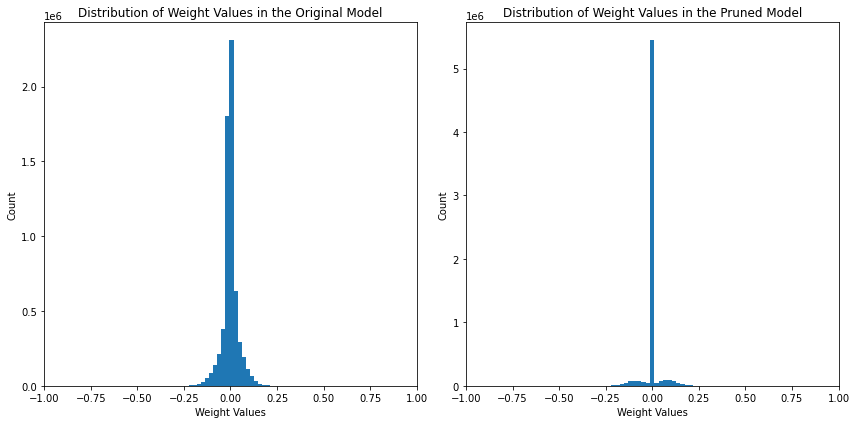

In [17]:
# Visualize model parameter changes and model size changes of VGG-8
print(f'Number of nonzero parameters in original model: {count_nonzero_params(model_VGG)}')
print(f'Number of nonzero parameters in pruned model: {count_nonzero_params(pruned_model)}')

# Plot the distribution of weights in the original and pruned models
weights_leorignal = []
weights_lepruned = []
for param in model_VGG.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)  
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()
